In [173]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.notebook import tqdm

review_data = load_files(r"/content/drive/My Drive/Colab Notebooks/assignment-02/movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

vectorizer = CountVectorizer(max_features=900, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
X_train = cp.asarray(X_train.T)
y_train = cp.asarray(y_train)

X_test = cp.asarray(X_test.T)
y_test = cp.asarray(y_test)

In [0]:
def sigmoid(x):
    return 1/(1+cp.exp(-x))

def h(X, th):
    bias = cp.ones(X.shape[1]).reshape(1,-1)

    a_1 = X
    a_1 = cp.concatenate((bias, a_1), axis=0)
    #print(a_1.shape)

    z_2 = cp.matmul(th[0], a_1)
    a_2 = sigmoid(z_2)
    a_2 = cp.concatenate((bias, a_2), axis=0)
    #print(a_2.shape)

    z_3 = cp.matmul(th[1], a_2)
    a_3 = sigmoid(z_3)
    a_3 = cp.concatenate((bias, a_3), axis=0)
    #print(a_3.shape)

    z_4 = cp.matmul(th[2], a_3)
    a_4 = sigmoid(z_4)
    #print(a_4.shape)
    return (a_4)


def J(l, h, th, lamb):
    #print(l.shape)
    #print(h.shape)
    single = (-l*cp.log(h) - (1-l)*cp.log(1-h))
    reg =  cp.mean(th[0] ** 2)+ cp.mean(th[1] ** 2) + cp.mean(th[2] ** 2)
    reg *=2
    reg *=lamb
    return (1/h.shape[1])*cp.sum(single) + reg


In [0]:
class train_classifier():
    def __init__(self, th):
        self.th=th
    def predict(self, X):
        bias = cp.ones(X.shape[1]).reshape(1,-1)

        a_1 = X
        a_1 = cp.concatenate((bias, a_1), axis=0)
        #print(a_1.shape)

        z_2 = cp.matmul(self.th[0], a_1)
        a_2 = sigmoid(z_2)
        a_2 = cp.concatenate((bias, a_2), axis=0)
        #print(a_2.shape)

        z_3 = cp.matmul(self.th[1], a_2)
        a_3 = sigmoid(z_3)
        a_3 = cp.concatenate((bias, a_3), axis=0)
        #print(a_3.shape)

        z_4 = cp.matmul(self.th[2], a_3)
        a_4 = sigmoid(z_4)
        
        
        result = cp.around(a_4).reshape(-1)
        #print(result)
        return result


In [0]:
def backProp(X, th, l, lamb):
    bias = cp.ones(X.shape[1]).reshape(1,-1)

    a_1 = X
    a_1 = cp.concatenate((bias, a_1), axis=0)
    #print(a_1.shape)

    z_2 = cp.matmul(th[0], a_1)
    a_2 = sigmoid(z_2)
    a_2 = cp.concatenate((bias, a_2), axis=0)
    #print(a_2.shape)

    z_3 = cp.matmul(th[1], a_2)
    a_3 = sigmoid(z_3)
    a_3 = cp.concatenate((bias, a_3), axis=0)
    #print(a_3.shape)

    z_4 = cp.matmul(th[2], a_3)
    a_4 = sigmoid(z_4)
    #print(a_4.shape)

    

    d_4 = a_4 - l
    #print(d_4.shape)

    #print(th[2].T.shape)
    #print(d_4.shape)
    #print(a_3.shape)
    d_3 = cp.matmul(th[2].T, d_4) * (a_3* (1-a_3))
    #print(d_3.shape)

    #print(th[1].T.shape)
    #print(d_3[1:,:].shape)
    #print(a_2.shape)
    d_2 = cp.matmul(th[1].T, d_3[1:,:]) * (a_2* (1-a_2))
    #print(d_2.shape)


    # let's make del_theta
    #print(a_3.shape)
    #print(d_4.shape)
    for i in range(d_4.shape[0]):
        if (i == 0): 
            #print(a_3.shape)
            #print(d_4[i,:].shape) 
            DMAT_3 = cp.sum(a_3*d_4[i,:], axis=1).reshape(-1,1)
            #print(DMAT_3.shape)
        else:     
            #print(DMAT_3.shape)
            #print(cp.sum(a_3*d_4[i,:], axis=1).reshape(-1,1).shape)
            DMAT_3 = cp.concatenate((DMAT_3,cp.sum(a_3*d_4[i,:], axis=1).reshape(-1,1)), axis=1)
        #print((a_3*d_4[i,:]).shape)
    #print(DMAT_3.T.shape)
    for i in range(d_3.shape[0]):
        if (i == 0): #not in concern
            pass
        elif (i==1):
            DMAT_2 = cp.sum(a_2*d_3[i,:], axis=1).reshape(-1,1)
            #print(DMAT_2.shape)
        else:     
            DMAT_2 = cp.concatenate((DMAT_2,cp.sum(a_2*d_3[i,:], axis=1).reshape(-1,1)), axis=1)
    #print(DMAT_2.T.shape)
    for i in range(d_2.shape[0]):
        if (i == 0): 
            pass
        elif(i==1):
            DMAT_1 = cp.sum(a_1*d_2[i,:], axis=1).reshape(-1,1)
        else:     
            DMAT_1 = cp.concatenate((DMAT_1,cp.sum(a_1*d_2[i,:], axis=1).reshape(-1,1)), axis=1)
    #print(DMAT_1.T.shape)


    #print(DMAT_1.T.shape, th[0].shape)


    m = d_4.shape[1]
    result=[DMAT_1.T/m + (lamb/(th[0].shape[0] * th[0].shape[1])) * th[0] , DMAT_2.T/m + (lamb/(th[1].shape[0] * th[1].shape[1])) * th[1] , DMAT_3.T/m + (lamb/(th[2].shape[0] * th[2].shape[1])) * th[2] ]
    return result



In [0]:
def GD(th, DMAT, lr):
    n_th = [th[0]-lr*DMAT[0], th[1]-lr*DMAT[1], th[2]-lr*DMAT[2]]
    return n_th

def accuracy(data, th, label):
    guess = cp.around(h(data, th)).reshape(-1)
    return cp.sum(cp.equal(label, guess)) / label.shape[0]


g_th = [cp.random.normal(size=(255, 901)), cp.random.normal(size=(105, 256)), cp.random.normal(size=(1,106))]

alpha = 0.3
lamb = 19

J_log_train = [J(y_train,  h(X_train, g_th), g_th, lamb)]
J_log_test = [J(y_test,  h(X_test, g_th), g_th, lamb)]


accuracy_train = [accuracy(X_train, g_th, y_train)]
accuracy_test = [accuracy(X_test, g_th, y_test)]


In [206]:
for i in tqdm(range(4000)):
    #if i==1000:
    #    alpha = 0.1
    Dmat = backProp(X_train, g_th, y_train, lamb)
    g_th = GD(g_th, Dmat, alpha)
    J_log_train.append(J(y_train, h(X_train, g_th), g_th, lamb))
    J_log_test.append(J(y_test, h(X_test, g_th), g_th, lamb))
    accuracy_train.append(accuracy(X_train, g_th, y_train))
    accuracy_test.append(accuracy(X_test, g_th, y_test))

1. Plot the loss curve  

plot the training loss at every iteration of gradient descent using the training data in blue color [5pt]  
plot the testing loss at every iteration of gradient descent using the testing data in red color [5pt]  
the both curves should be presented in one figure  

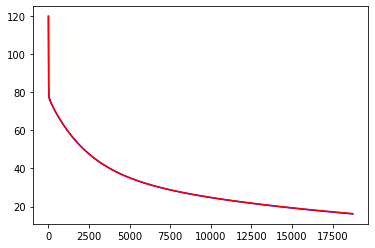

In [207]:
plt.plot(J_log_train,c='blue')
plt.plot(J_log_test,c='red')
plt.show()

2. Plot the accuracy curve  

plot the training accuracy (%) at every iteration of gradient descent using the training data in blue color [5pt]  
plot the testing accuracy (%) at every iteration of gradient descent using the testing data in red color [5pt]  
the both curves should be presented in one figure

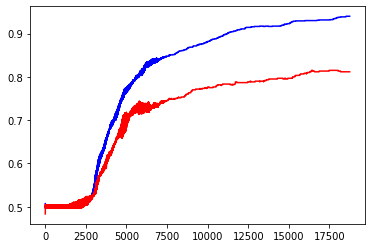

In [208]:
plt.plot(accuracy_train,c='blue')
plt.plot(accuracy_test,c='red')
plt.show()

3. Plot the quantitative results  

Training results  

print the confusion matrix using the function confusion_matrix based on the training data [1pt]  
print the classification report using the function classification_report based on the training data [1pt]  
print the accuracy score using the function accuracy_score based on the training data [1pt]  


Testing results  

print the confusion matrix using the function confusion_matrix based on the testing data [1pt]  
print the classification report using the function classification_report based on the testing data [1pt]  
print the accuracy score using the function accuracy_score based on the testing data [1pt]  


In [209]:
classifier = train_classifier(g_th)
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

cpu_y_train = cp.asnumpy(y_train)
cpu_y_pred_train = cp.asnumpy(y_pred_train)

cpu_y_test = cp.asnumpy(y_test)
cpu_y_pred_test = cp.asnumpy(y_pred_test)

print(confusion_matrix(cpu_y_train,cpu_y_pred_train))
print(classification_report(cpu_y_train,cpu_y_pred_train))
print(accuracy_score(cpu_y_train, cpu_y_pred_train))
print('=================================================================')
print(confusion_matrix(cpu_y_test,cpu_y_pred_test))
print(classification_report(cpu_y_test,cpu_y_pred_test))
print(accuracy_score(cpu_y_test, cpu_y_pred_test))


[[657  41]
 [ 43 659]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       698
           1       0.94      0.94      0.94       702

    accuracy                           0.94      1400
   macro avg       0.94      0.94      0.94      1400
weighted avg       0.94      0.94      0.94      1400

0.94
[[247  55]
 [ 58 240]]
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       302
           1       0.81      0.81      0.81       298

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600

0.8116666666666666
